In [1]:
import numpy as np
from numpy.linalg.linalg import norm
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#import tensorflow as tf
#from tensorflow.keras.models import Model
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation, Flatten
#from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LayerNormalization
#from keras.optimizers import Adam
#from keras.optimizers import RMSprop
#from keras.regularizers import l2
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.markers import MarkerStyle
import cartopy.crs as ccrs
import cartopy.feature as cfeaturel
import pandas as pd


# データの読み込み
data = np.load('/work/gi55/i55233/data/results/bsiso_eeof/prepro_anomaly_7vals.npz')
print('data = ', data.files)

data =  ['lat', 'lon', 'time', 'real_time', 'olr', 'u850', 'v850', 'u200', 'v200', 'h850', 'pr_wtr']


In [14]:
lat = data['lat'][24:49]
lon = data['lon']
olr = data['olr'][80:,24:49,:]
#u850 = data['u850'][80:-80,24:49,:]
#v850 = data['v850'][80:-80,24:49,:]
#u200 = data['u200'][80:-80,24:49,:]
#v200 = data['v200'][80:-80,24:49,:]
#h850 = data['h850'][80:-80,24:49,:]
#pr_wtr = data['pr_wtr'][80:-80,24:49,:]
time = data['time'][80+10:]  # 射影後にデータが10日進むため、時刻の方を前進させておく
real_time = pd.to_datetime(time, unit='h', origin=pd.Timestamp('1800-01-01')) # 時刻をdatetime型に変換
#print(lat.shape, lon.shape, olr.shape, u850.shape, v850.shape, u200.shape, v200.shape, h850.shape, pr_wtr.shape)
print(real_time[0], real_time[-1])

1979-04-01 00:00:00 2022-12-31 00:00:00


In [8]:
# bsiso index (eEOF) 読み込み
data_file = '/work/gi55/i55233/data/archive/kikuchi_mjo_index.dat'

year    = np.loadtxt(data_file, usecols = 0, dtype = int)
month   = np.loadtxt(data_file, usecols = 1, dtype = int)
day     = np.loadtxt(data_file, usecols = 2, dtype = int)
PC_bp     = np.loadtxt(data_file, usecols = [3, 4])
#PCy     = np.loadtxt(data_file, usecols = 4)
phase   = np.loadtxt(data_file, usecols = 5, dtype = int)
Amp_nrm_bsiso = np.loadtxt(data_file, usecols = 6, dtype = float)
#index = np.loadtxt(data_file)

print('month = ', month.shape)
print('phase = ', phase.shape)
print( 'PC = ', PC_bp.shape)
print('Amp_nrm_bsiso = ', Amp_nrm_bsiso.shape)
print(year, month, day)

month =  (7588,)
phase =  (7588,)
PC =  (7588, 2)
Amp_nrm_bsiso =  (7588,)
[2002 2002 2002 ... 2022 2022 2022] [ 3  3  3 ... 12 12 12] [22 23 24 ... 27 28 29]


# real-time 予測向けにデータを射影

In [15]:
X_10lag = olr[:-10].reshape(-1, 25*144)
X_5lag  = olr[5:-5].reshape(-1, 25*144)
X_0lag  = olr[10:].reshape(-1, 25*144)
# 空間方向に結合
X_total = np.concatenate([X_10lag, X_5lag, X_0lag], axis=1)
print('X_total = ',X_total.shape)

X_total =  (15981, 10800)


In [16]:
# データをEEOFに射影
df = np.load('/work/gi55/i55233/data/results/bsiso_eeof/eeof-mjo.npz')
print(df.files)
EEOF = df['EEOFs'].transpose(1,2,3,0)
EEOF = EEOF.reshape(-1, 25*144, 3)
EEOF = EEOF.reshape(-1, 3600*3)
print(EEOF.shape)
U = df['U']
print(U.shape, EEOF.shape)
rt_PCs = X_total @ U
print(rt_PCs.shape)
rt_PCs_norm = rt_PCs / rt_PCs.std(axis=0)[np.newaxis,:]
print(real_time.shape)

['lon', 'lat', 'time', 'EEOFs', 'PC', 'D', 'V', 's', 'U']
(3871, 10800)
(10800, 3871) (3871, 10800)
(15981, 3871)
(15981,)


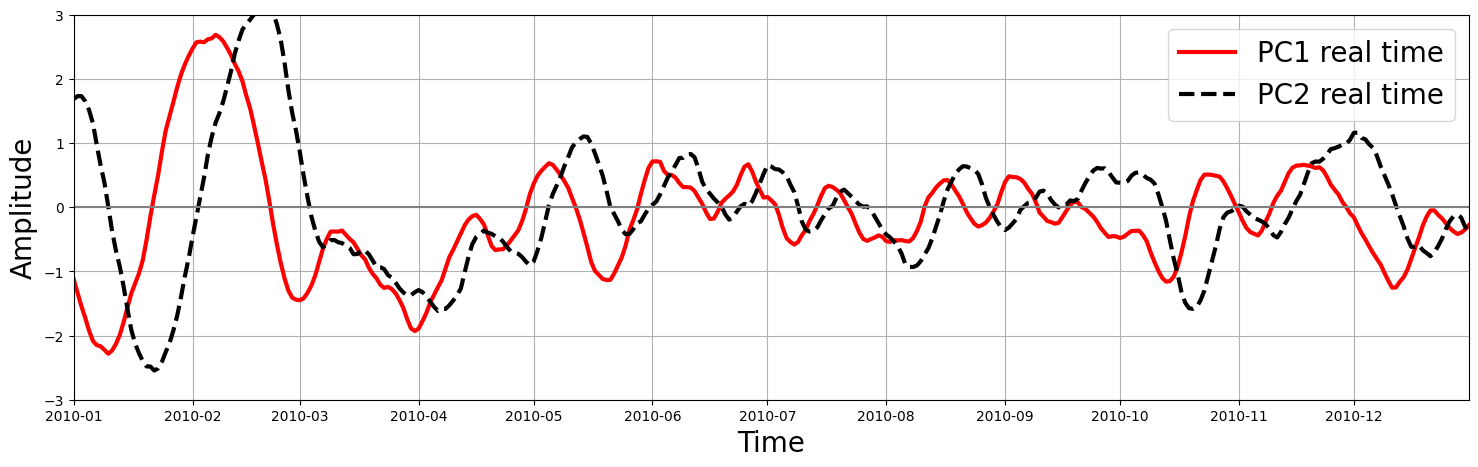

In [17]:
rt = real_time
idx = np.where((rt.year == 2010) & (rt.month <= 12))[0] 
tt = rt[idx]
bp_PCs = PC_bp[10:]
plt.figure(figsize=(18,5))
#plt.plot(tt, bp_PCs[idx,1], label='PC1 band pass', color='k', linewidth=2, alpha=0.7)
#plt.plot(tt, bp_PCs[idx,0], linestyle='--', label='PC2 band pass', color='k', linewidth=2, alpha=0.7)
plt.plot(tt, -rt_PCs_norm[idx,0], label='PC1 real time', color='r', linewidth=3)
plt.plot(tt, -rt_PCs_norm[idx,1], linestyle='--', label='PC2 real time', color='k', linewidth=3)
plt.hlines(0, tt[0], tt[-1], 'grey', linestyle='-')
plt.xlim(tt[0], tt[-1])
plt.ylim(-3, 3)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
#plt.legend(fontsize=20, loc='upper right', ncol=2)
plt.legend(fontsize=20, loc='upper right')
plt.grid()
plt.show()

In [19]:
np.savez('/work/gi55/i55233/data/results/bsiso_eeof/mjo_rt-PCs.npz',rt_PCs=rt_PCs[:,:10], time=time)

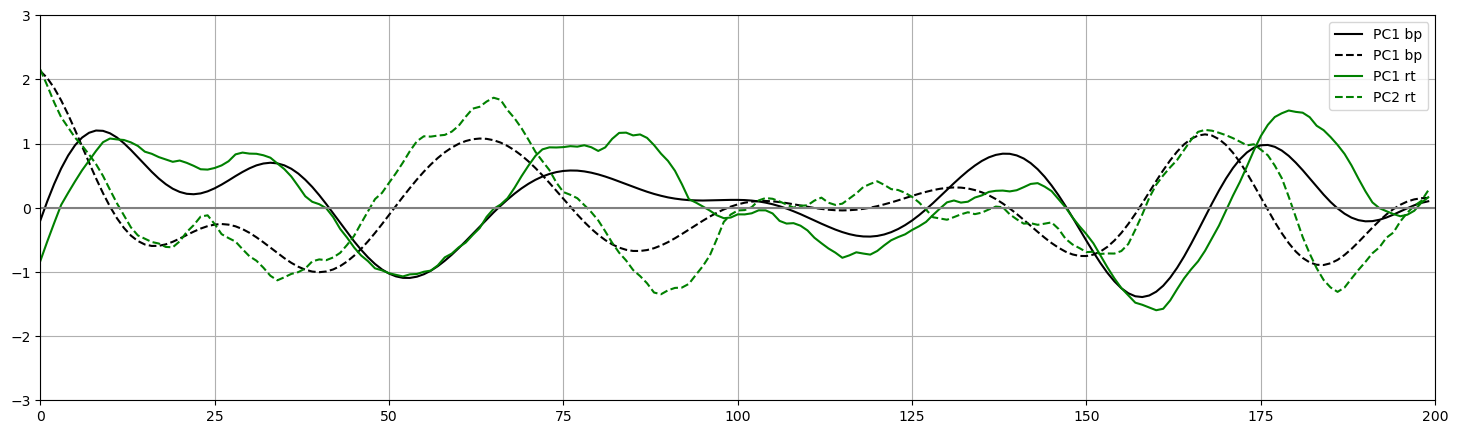

In [11]:
rt = real_time

bp_PCs = PC_bp[10:]
plt.figure(figsize=(18,5))
plt.plot(bp_PCs[200:400,1], label='PC1 bp', color='k')
plt.plot(bp_PCs[200:400,0], linestyle='--', label='PC1 bp', color='k')
plt.plot(-rt_PCs_norm[200:400,0], label='PC1 rt', color='g')
plt.plot(rt_PCs_norm[200:400,1], linestyle='--', label='PC2 rt', color='g')
plt.hlines(0, 0, 200, 'grey', linestyle='-')
plt.xlim(0, 200)
plt.ylim(-3, 3)
plt.legend()
plt.grid()
plt.show()